# Анализ убытков приложения Procrastinate Pro+


**План исследования**

1. Изучить, откуда приходят пользователи и какими устройствами пользуются,
2. Сколько стоит привлечение пользователей из различных рекламных каналов,
3. Сколько денег приносит каждый клиент,
4. Когда расходы на привлечение клиента окупаются,
5. Какие факторы мешают привлечению клиентов.


**Описание данных**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):
- User Id — уникальный идентификатор пользователя;
- Device — категория устройства пользователя;
- Session start — дата и время начала сессии;
- Session End — дата и время окончания сессии;
- Channel — идентификатор рекламного источника, из которого пришел пользователь;
- Region - страна пользователя.

Таблица orders_log_short (информация о заказах):
- User Id — уникальный id пользователя, который сделал заказ;
- Event Dt — дата и время покупки;
- Revenue — выручка.

Таблица costs_short (информация о затратах на маркетинг):
- Channel — идентификатор рекламного источника;
- Dt — дата;
- Costs — затраты на этот рекламный источник в этот день.

## Изучение входных данных

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# загрузим данные о визитах, заказах и рекламных тратах в переменные
visits, orders, costs = (
    pd.read_csv('visits_info_short.csv'),
    pd.read_csv('orders_info_short.csv'),
    pd.read_csv('costs_info_short.csv'),
)    

In [3]:
# изучим исходные данные
print('VISITS')
visits.info()
print('----------------------------------------------')
print('')
print('ORDERS')
orders.info()
print('----------------------------------------------')
print('')
print('COSTS')
costs.info()

VISITS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
----------------------------------------------

ORDERS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
----------------------------------------------

COSTS
<cla

In [4]:
# приведем названия столбцов к нижнему регистру
visits.columns = [x.lower() for x in visits.columns]
orders.columns = [x.lower() for x in orders.columns]
costs.columns = [x.lower() for x in costs.columns]

In [5]:
# заменим пробелы нижним подчеркиванием
visits = visits.rename(columns={'user id':'user_id', 'session start':'session_start', 'session end':'session_end'})
orders = orders.rename(columns={'user id':'user_id', 'event dt':'event_dt'})

In [6]:
# изменим тип данных в столбцах с датой
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [7]:
# проверим результаты изменений
print('VISITS')
visits.info()
print('----------------------------------------------')
print('')
print('ORDERS')
orders.info()
print('----------------------------------------------')
print('')
print('COSTS')
costs.info()

VISITS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
----------------------------------------------

ORDERS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtyp

In [8]:
# проверим данные на полные дубликаты
print('Кол-во дубликатов в visits:', visits.duplicated().sum())
print('Кол-во дубликатов в orders:', orders.duplicated().sum())
print('Кол-во дубликатов в costs:', costs.duplicated().sum())

Кол-во дубликатов в visits: 0
Кол-во дубликатов в orders: 0
Кол-во дубликатов в costs: 0


**Вывод**

В данном разделе были приведены к стандарту исходные данные. Названия столбцов преобразованы к нижнему регистру, пробелы заменены нижним подчеркиванием. Столбцы с датой преобразованы в соответствующий им тип даты. Пропусков и дубликатов в исходных данных не обнаружено.

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

In [9]:
# функция для создания пользовательских профилей
def get_profiles(visits, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [10]:
# функция для расчёта удержания
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
# функция для расчёта конверсии
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [13]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [14]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 14))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм', fontsize=14)
    plt.title('Удержание платящих пользователей', fontsize=16)

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм', fontsize=14)
    plt.title('Удержание неплатящих пользователей', fontsize=16)

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения', fontsize=14)
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        ), fontsize=16
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения', fontsize=14)
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        ), fontsize=16
    )
    
    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(16, 7))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм', fontsize=14)
    plt.title('Конверсия пользователей', fontsize=16)

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения', fontsize=14)
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon), fontsize=16)

    plt.tight_layout()
    plt.show()

In [16]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 14))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм', fontsize=14)
    plt.title('LTV', fontsize=16)

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения', fontsize=14)
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon), fontsize=16)

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения', fontsize=14)
    plt.title('Динамика стоимости привлечения пользователей', fontsize=16)

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм', fontsize=14)
    plt.title('ROI', fontsize=16)

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения', fontsize=14)
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon), fontsize=16)

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

In [17]:
# построим профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную дату привлечения пользователей.

In [18]:
# минимальная дата привлечения пользователей
min_analysis_date = profiles['dt'].min()

# максимальная дата привлечения пользователей
observation_date = profiles['dt'].max()

# горизонт анализа
horizon_days = 14 

print('Минимальная дата привлечения пользователей:', min_analysis_date)
print('Максимальная дата привлечения пользователей:', observation_date)

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Выясним из каких стран, с каких устройств и из каких рекламных источников клиенты заходят в приложение. Найдем доли платящих клиентов для каждой таблицы и отсортируем их в порядке убывания.

In [19]:
# группировка по стране
country_groupped = profiles.groupby('region', as_index = False)\
    .agg({'user_id':'nunique', 'payer':'mean'})\
    .sort_values(by='payer', ascending = False)

# округление доли платящих пользователей до 2-х знаков после запятой
country_groupped['payer'] = country_groupped['payer'].round(2) 

# расчет доли уникальных пользователей от общего числа пользователей
country_groupped['part_of_all'] = (
    country_groupped['user_id'].apply(
    lambda x: x / country_groupped['user_id'].sum())\
    .round(2)
)

display(country_groupped)

,region,user_id,payer,part_of_all
3,United States,100002,0.07,0.67
1,Germany,14981,0.04,0.10
2,UK,17575,0.04,0.12
0,France,17450,0.04,0.12


Приложением пользуются из Америки (67%), Германии (10%), Великобритании (12%) и Франции (12%). Доля платящих пользователей выше у американских пользователей и составляет 7%, в то время как у остальных стран доля примерно на одном уровне - 4%.

In [20]:
# группировка по устройству
device_groupped = profiles.groupby('device', as_index = False)\
    .agg({'user_id':'nunique', 'payer':'mean'})\
    .sort_values(by='payer', ascending = False)

# округление доли платящих пользователей до 2-х знаков после запятой
device_groupped['payer'] = device_groupped['payer'].round(2) 

# расчет доли уникальных пользователей от общего числа пользователей
device_groupped['part_of_all'] = (
    device_groupped['user_id'].apply(
    lambda x: x / device_groupped['user_id'].sum())\
    .round(2)
)

display(device_groupped)

,device,user_id,payer,part_of_all
1,Mac,30042,0.06,0.20
3,iPhone,54479,0.06,0.36
0,Android,35032,0.06,0.23
2,PC,30455,0.05,0.20


В качестве устройств используются по большей части айфоны (36%). Доли макбуков, андройдов и PC примерно на одном уровне ~ 20%. Платежеспособность пользователей с макбуками, айфонами и андройдами схожа и равняется 6%. Меньше всего оплат приходит от пользователей PC - 5%.

In [21]:
# группировка по рекламному источнику
channel_groupped = profiles.groupby('channel', as_index = False)\
      .agg({'user_id':'nunique', 'payer':'mean'})\
      .sort_values(by='payer', ascending = False)

# округление доли платящих пользователей до 2-х знаков после запятой
channel_groupped['payer'] = channel_groupped['payer'].round(2) 

# расчет доли уникальных пользователей от общего числа пользователей
channel_groupped['part_of_all'] = (
    channel_groupped['user_id'].apply(
    lambda x: x / channel_groupped['user_id'].sum())\
    .round(2)
)

display(channel_groupped)

,channel,user_id,payer,part_of_all
1,FaceBoom,29144,0.12,0.19
0,AdNonSense,3880,0.11,0.03
9,lambdaMediaAds,2149,0.10,0.01
6,TipTop,19561,0.10,0.13
5,RocketSuperAds,4448,0.08,0.03
7,WahooNetBanner,8553,0.05,0.06
8,YRabbit,4312,0.04,0.03
3,MediaTornado,4364,0.04,0.03
2,LeapBob,8553,0.03,0.06
4,OppleCreativeMedia,8605,0.03,0.06


Самыми популярными каналами привлечения пользователей являются FaceBoom и TipTop. По органическому трафику пришло 56,4 тыс.чел., однако доля платящих клиентов здесь самая низкая и составляет 2%. Более склонны к покупкам пользователи, привлеченные из каналов FaceBoom (12%), AdNonSense (11%), lambdaMediaAds (10%) и TipTop (10%).

**Вывод**

На основании проведенных расчетов выявлено, что приложением пользуются в большинстве случаев клиенты из Америки. Доля платящих пользователей у них выше чем у остальных клиентов из других стран. В качестве устройств в основном используются айфоны. Владельцы айфонов и макбуков имеют более высокую платежеспособность относительно остальных девайсов. Самыми популярными каналами привлечения пользователей являются FaceBoom и TipTop. Более склонны к покупкам пользователи, привлеченные из каналов FaceBoom, AdNonSense, lambdaMediaAds и TipTop. Так же стоит отметить органический трафик, который привлек 38% всех пользователей за исследуемый период с долей платящих клиентов 2%. 

## Анализ затрат на маркетинг 

In [22]:
# общая сумма расходов на маркетинг
investments_total = round(costs.costs.sum(),2)
print('Общая сумма расходов на маркетинг:', investments_total)

Общая сумма расходов на маркетинг: 105497.3


In [23]:
# распределение трат на маркетинг по источникам
investments = (
    pd.pivot_table(
        costs,
        index=['channel'],
        values=['costs'],
        aggfunc=['sum']
    ).reset_index()
)
               
# расчет доли затрат от общего числа затрат на рекламу
investments['part_of_all'] = round(investments['sum'] / investments_total, 2)
investments = investments.sort_values(by=['part_of_all'], ascending=False)
investments.columns = ['channel', 'costs', 'part_of_all']

display(investments)

,channel,costs,part_of_all
6,TipTop,54751.30,0.52
1,FaceBoom,32445.60,0.31
7,WahooNetBanner,5151.00,0.05
0,AdNonSense,3911.25,0.04
2,LeapBob,1797.60,0.02
4,OppleCreativeMedia,2151.25,0.02
5,RocketSuperAds,1833.00,0.02
3,MediaTornado,954.48,0.01
8,YRabbit,944.22,0.01
9,lambdaMediaAds,1557.60,0.01


Основная доля затрат на маркетинг приходится на каналы **TipTop** и **FaceBoom**, доля которых составила 52% и 31% соответственно, что составило более 80% бюджета.

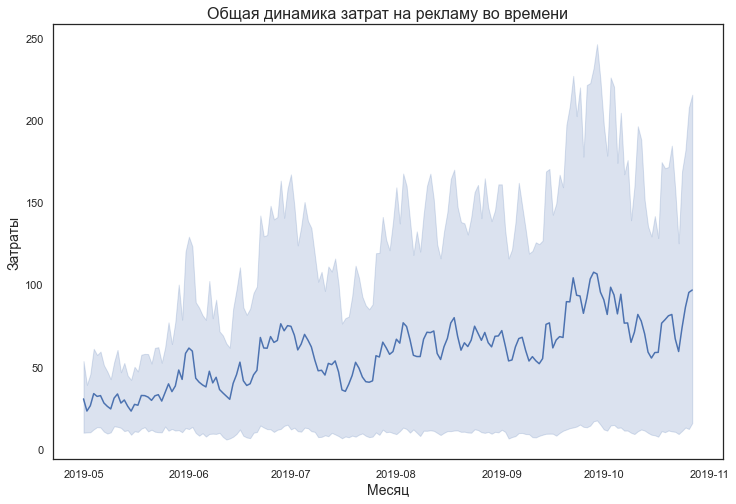

In [24]:
# общая динамика затрат на рекламу во времени
plt.figure(figsize=(12, 8))
sns.set_theme(style="white")
sns.lineplot(data=costs, x='dt', y='costs')
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Затраты', fontsize=14)
plt.title('Общая динамика затрат на рекламу во времени', fontsize=16)
plt.show()

Общие затраты на маркетинг растут ежемесячно растут. Проверим динамику затрат по источникам.

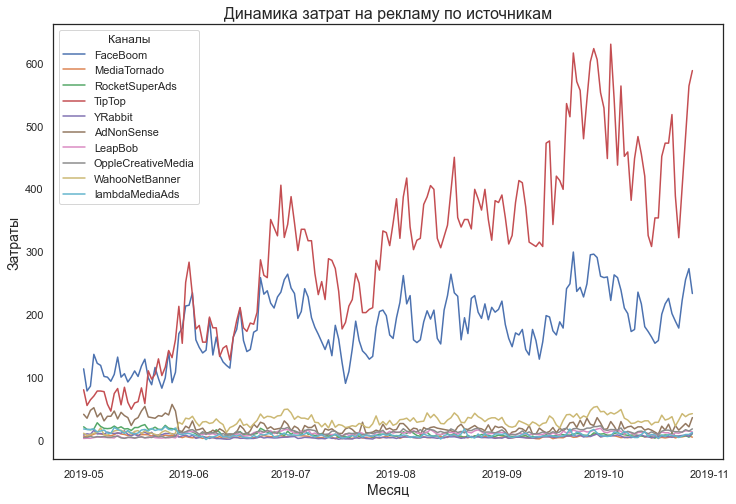

In [25]:
# Динамика затрат на рекламу по источникам
plt.figure(figsize=(12, 8))
sns.lineplot(data=costs, x='dt', y='costs', hue='channel')
plt.legend(title='Каналы')
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Затраты', fontsize=14)
plt.title('Динамика затрат на рекламу по источникам', fontsize=16)
plt.show()

Исходя из графика видно, что затраты растут только для двух каналов: **FaceBoom** и **TipTop**. Расходы на остальные каналы с течением времени находятся примерно на одном уровне.

In [26]:
# исключим пользователей с органическим трафиком из таблицы profiles
profiles = profiles.query('channel != "organic"')

In [27]:
# расчет среднего САС на одного пользователя для всего проекта
cac_by_one = profiles['acquisition_cost'].mean()
print('Средний САС на одного пользователя:', round(cac_by_one, 2))

Средний САС на одного пользователя: 1.13


In [28]:
# расчет среднего САС по проекту для каждого источника
cac_by_channel = (
    profiles.groupby('channel', as_index = False)['acquisition_cost'].mean()
    .sort_values(by='acquisition_cost', ascending = False)
)    

cac_by_channel.columns=['channel', 'cac']
cac_by_channel['cac'] = cac_by_channel['cac'].round(2)

cac_by_channel

,channel,cac
6,TipTop,2.80
1,FaceBoom,1.11
0,AdNonSense,1.01
9,lambdaMediaAds,0.72
7,WahooNetBanner,0.60
5,RocketSuperAds,0.41
4,OppleCreativeMedia,0.25
8,YRabbit,0.22
3,MediaTornado,0.22
2,LeapBob,0.21


Самым дорогим каналом привлечения является TipTop со средним САС 2.8 у.е. При этом средний САС на пользователя по всему проекту составил только 1.13! Дешевле всего обходятся пользователи из канала LeapBob c САС равным 0.21.

**Вывод**

Общая сумма маркетинговых расходов составила 105497 у.е. Основная доля затрат приходится на каналы TipTop и FaceBoom, доля которых составила 52% и 31% соответственно. При этом, общая сумма затрат на эти каналы растет из месяца в месяц, в то время как уровень затрат на остальные каналы стабилен и меняется незначительно. Самым дорогим каналом привлечения является TipTop со средним САС 2.8 у.е., тогда как средний САС на одного пользователя по всему проекту равен 1.13 у.е.

## Расчет окупаемости рекламы

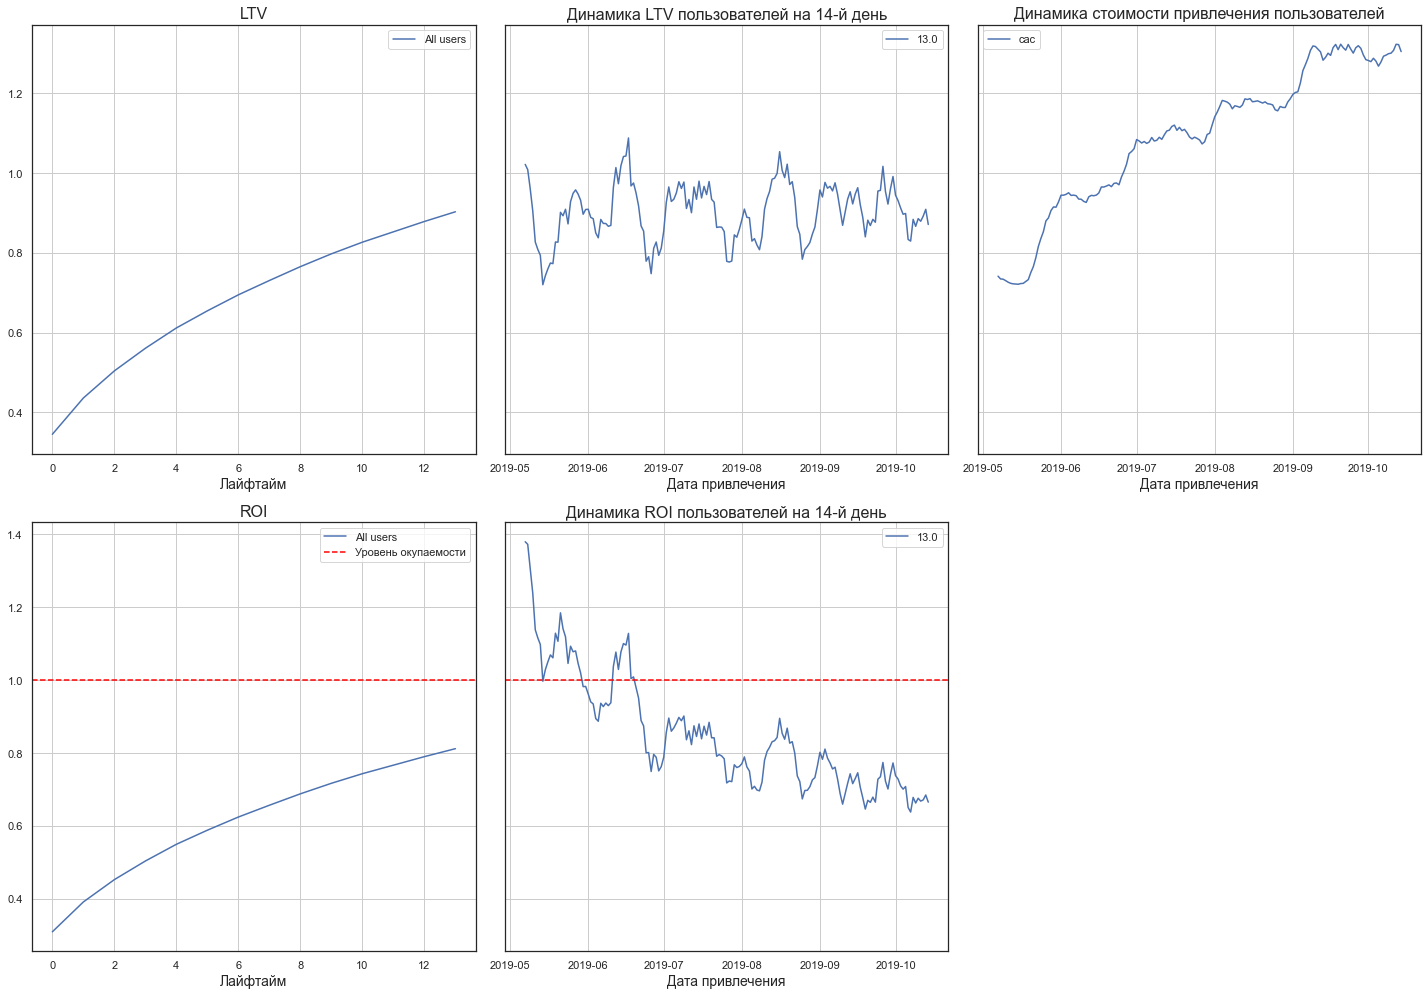

In [29]:
# смотрим общую окупаемость
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Из графиков видно, что реклама не окупается. Общий ROI по истечению двух недель не достиг уровня окупаемости. На LTV влияет сезонный фактор, но этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей. С ростом САС, падает ROI. Значит, дело в увеличении рекламного бюджета.

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, каналу привлечения и устройству первого посещения.
Начнём с разбивки по устройствам: передадим параметру `dimensions` столбец `device`.

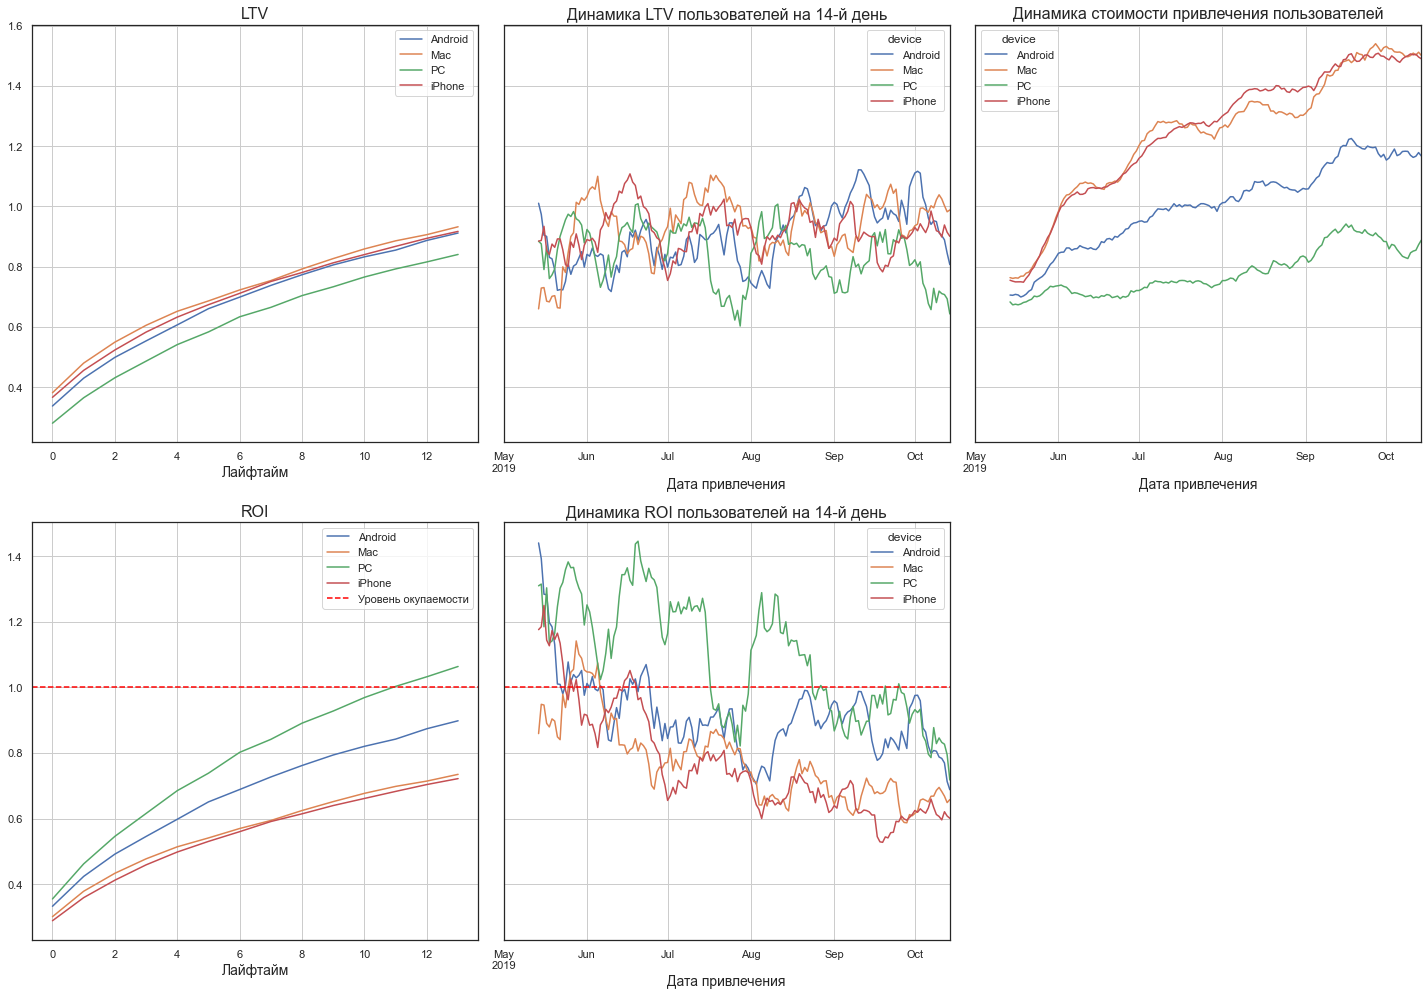

In [30]:
# смотрим окупаемость с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Реклама окупается только у пользователей РС. Для всех остальных девайсов за 14 дней реклама не окупается. LTV всё так же подвержен сезонности, но стабилен. Стоимость привлечения сильно выросла для всех устройств, в особенности для пользователей Мас и IPhone. Проверим окупаемость по странам.

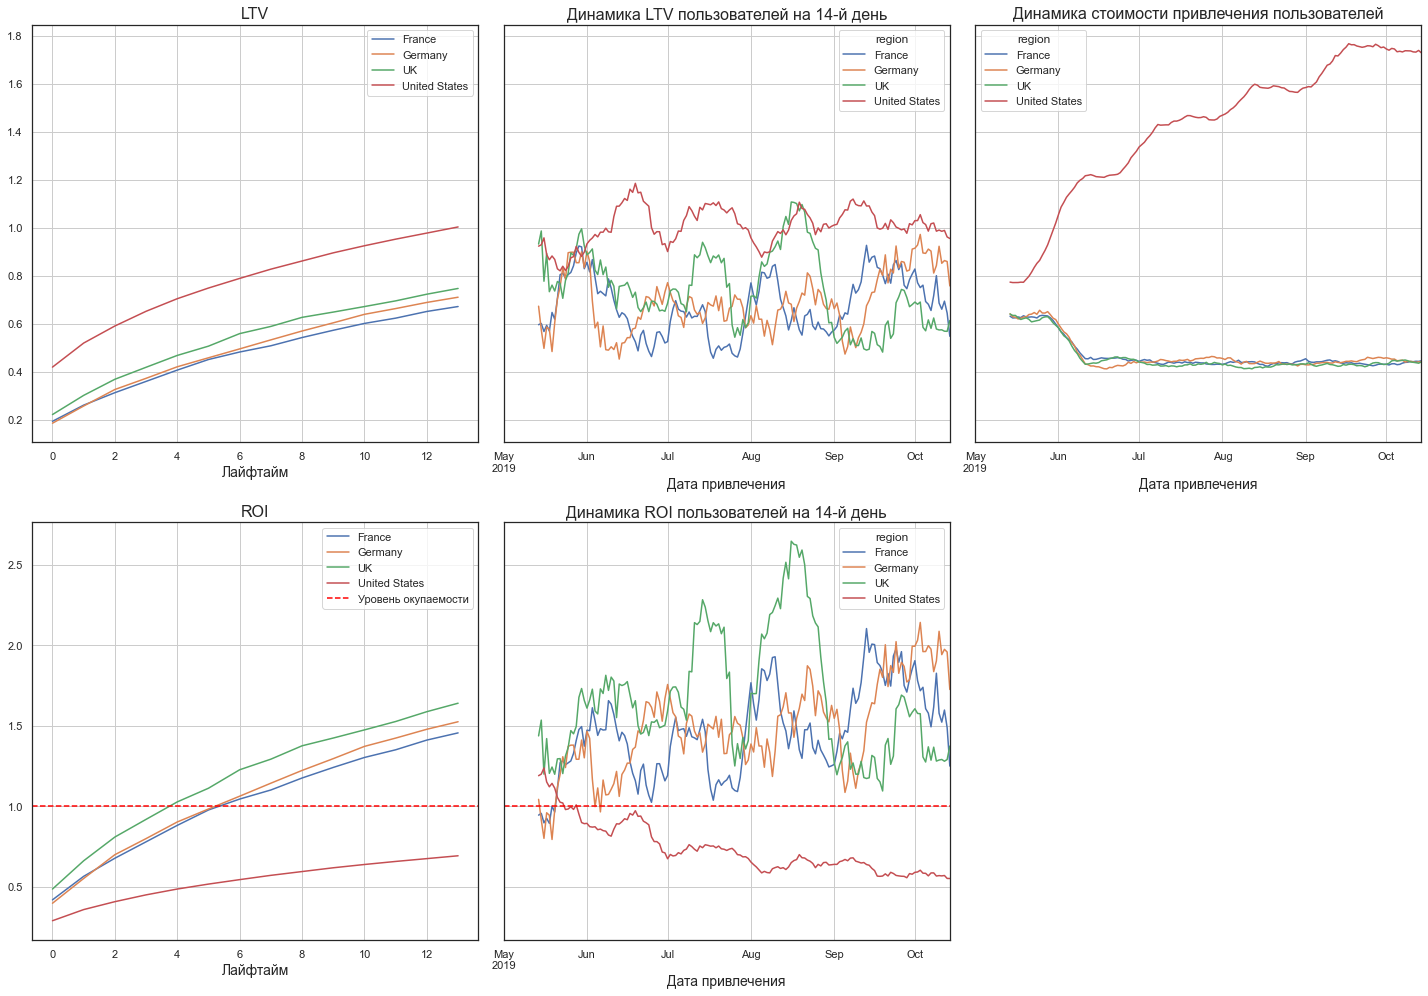

In [31]:
# смотрим окупаемость с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

С ростом расходов на маркетинг в Америку с июня месяца клиенты перестали окупаться. Если в начале периода стоимость привлечения американских пользователей составляла около 0.8 у.е., то к концу октября каждый новый пользователь обходился компании в 1.7 у.е., что в 2.1 раз больше. Учитывая то, что на пользователей из Америки приходится 67% всех пользователей, становится ясно, почему инвестиции в рекламу перестали окупаться. Так же стоит отметить, что LTV для Америки заметно выше чем для других стран, значит качество пользователей там выше. Инвестиции в остальные страны окупаются за 4-5 дней, при этом стоимость привлечения пользователей для них стабильна и даже снизилась по сравнению с маем 2019.

Проанализируем окупаемость по источникам привлечения.

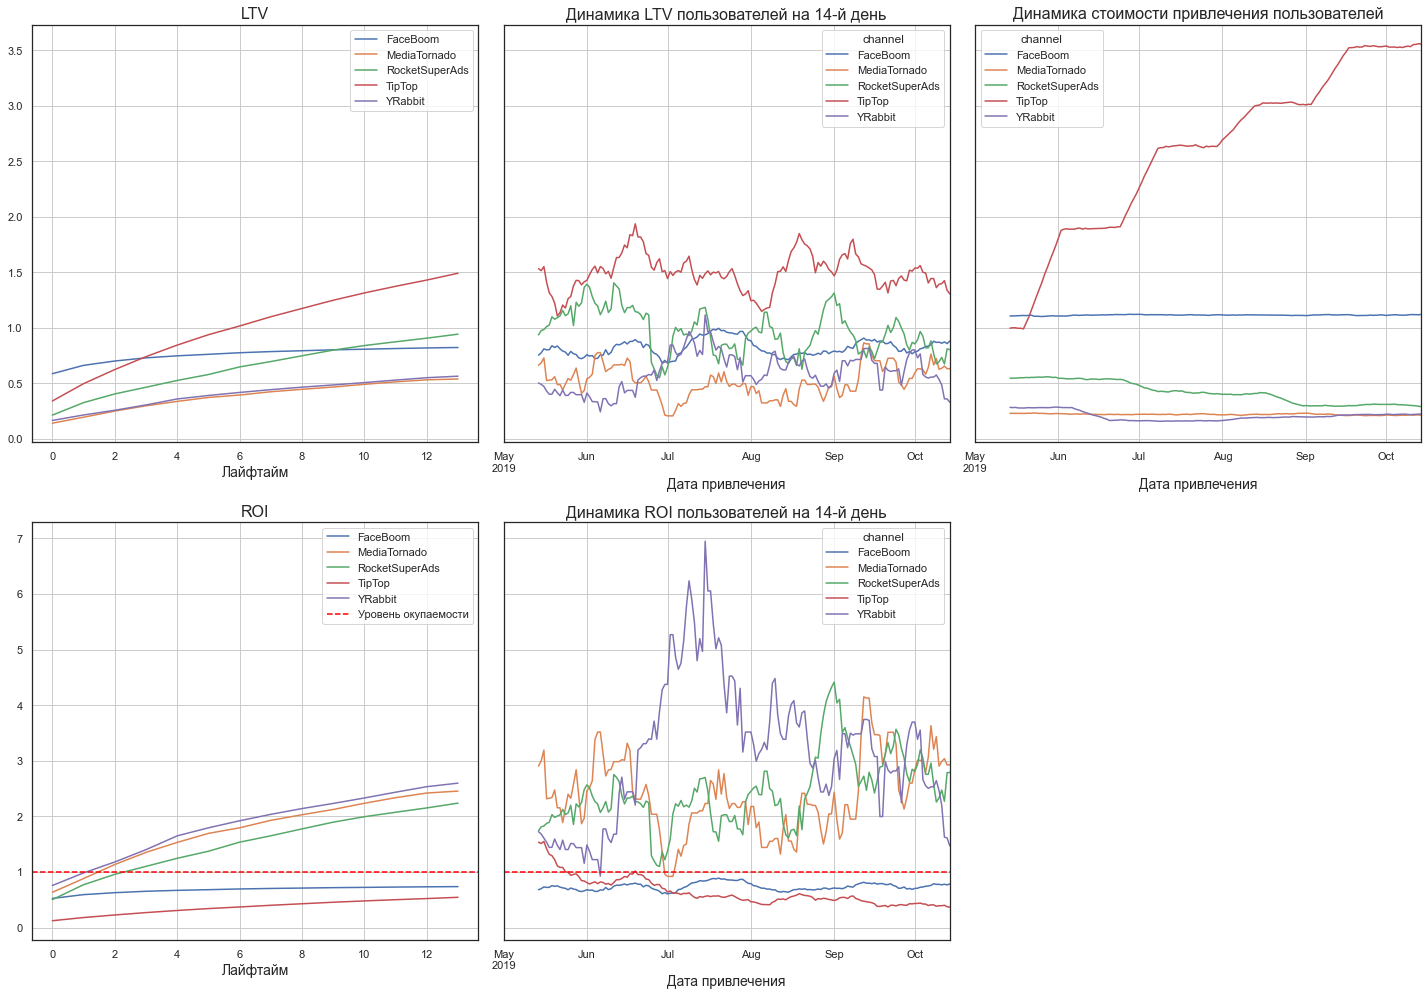

In [32]:
# смотрим окупаемость с разбивкой по источникам привлечения отдельно для пользователей из США
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "United States"'), orders, observation_date, horizon_days, dimensions=['channel'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Каналы FaceBoom и TipTop в США стабильно не окупаются. При чем если расходы на FaceBoom распределены равномерно, то динамика САС для TipTop растет ежемесячно на протяжении всего исследуемого периода. Отдельном отметим LTV для источника TipTop, динамика которого ярко выржена на графике, относительно остальных каналов. Так же интересным является рост ROI для канала YRabbit с июня по август, вероятно из-за снижения САС.

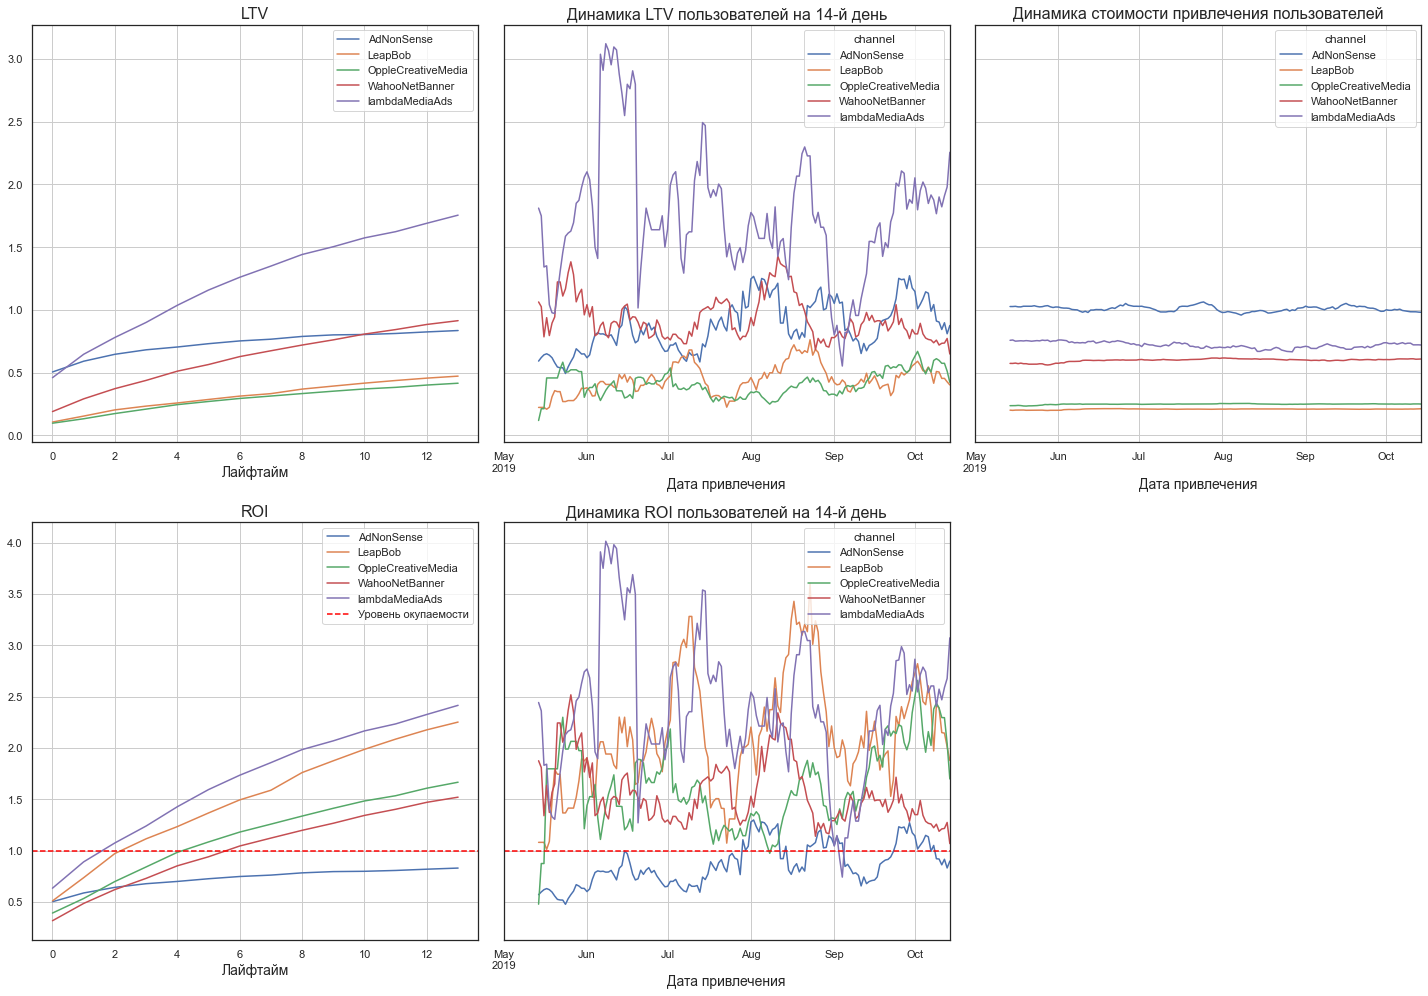

In [33]:
# смотрим окупаемость с разбивкой по источникам привлечения отдельно для пользователей из Европы
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region != "United States"'), orders, observation_date, horizon_days, dimensions=['channel'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Для Европейских стран динамика САС стабильна, однако канал AdNoNSense за 14 дней не окупается. Необходимо снизить расходы на привлечение новых клиентов из этого источника, чтобы инвестици окупались в установленный бизнесом срок. Очень хороший показатель и динамику LTV имеет канал lambdaMediaAds при не столь высоких расходах, в связи с чем окупаемость этого источника выше остальных и составляет менее 2-х дней.

Построим и проанализируем графики конверсии и удержания с разбивкой по устройствам, странам и рекламным каналам.

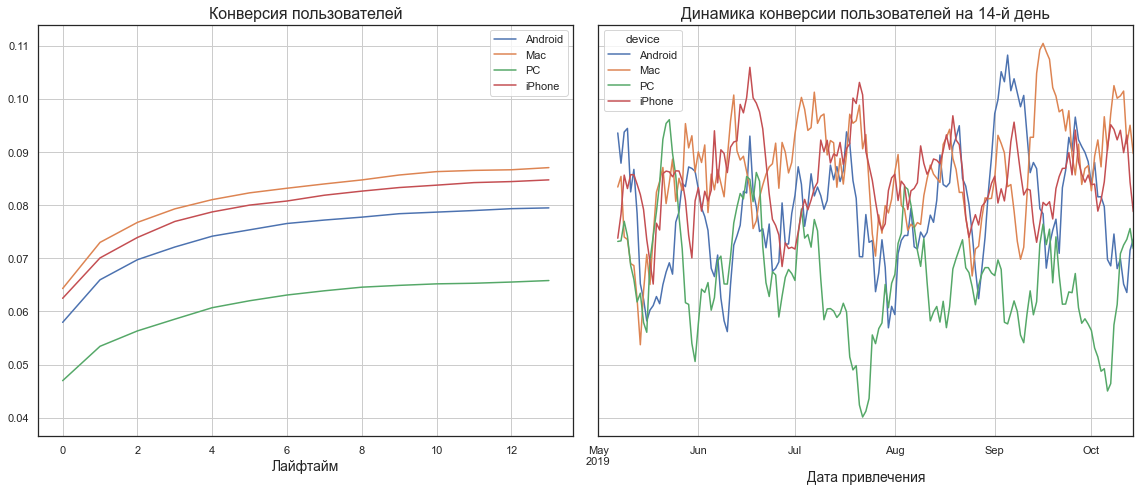

In [34]:
# смотрим конверсию с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи Mac и IPhone конвертируются хорошо, причем постоянно. Хуже представлена конверсия у пользователей РС. Посмотрим на графики удержания.

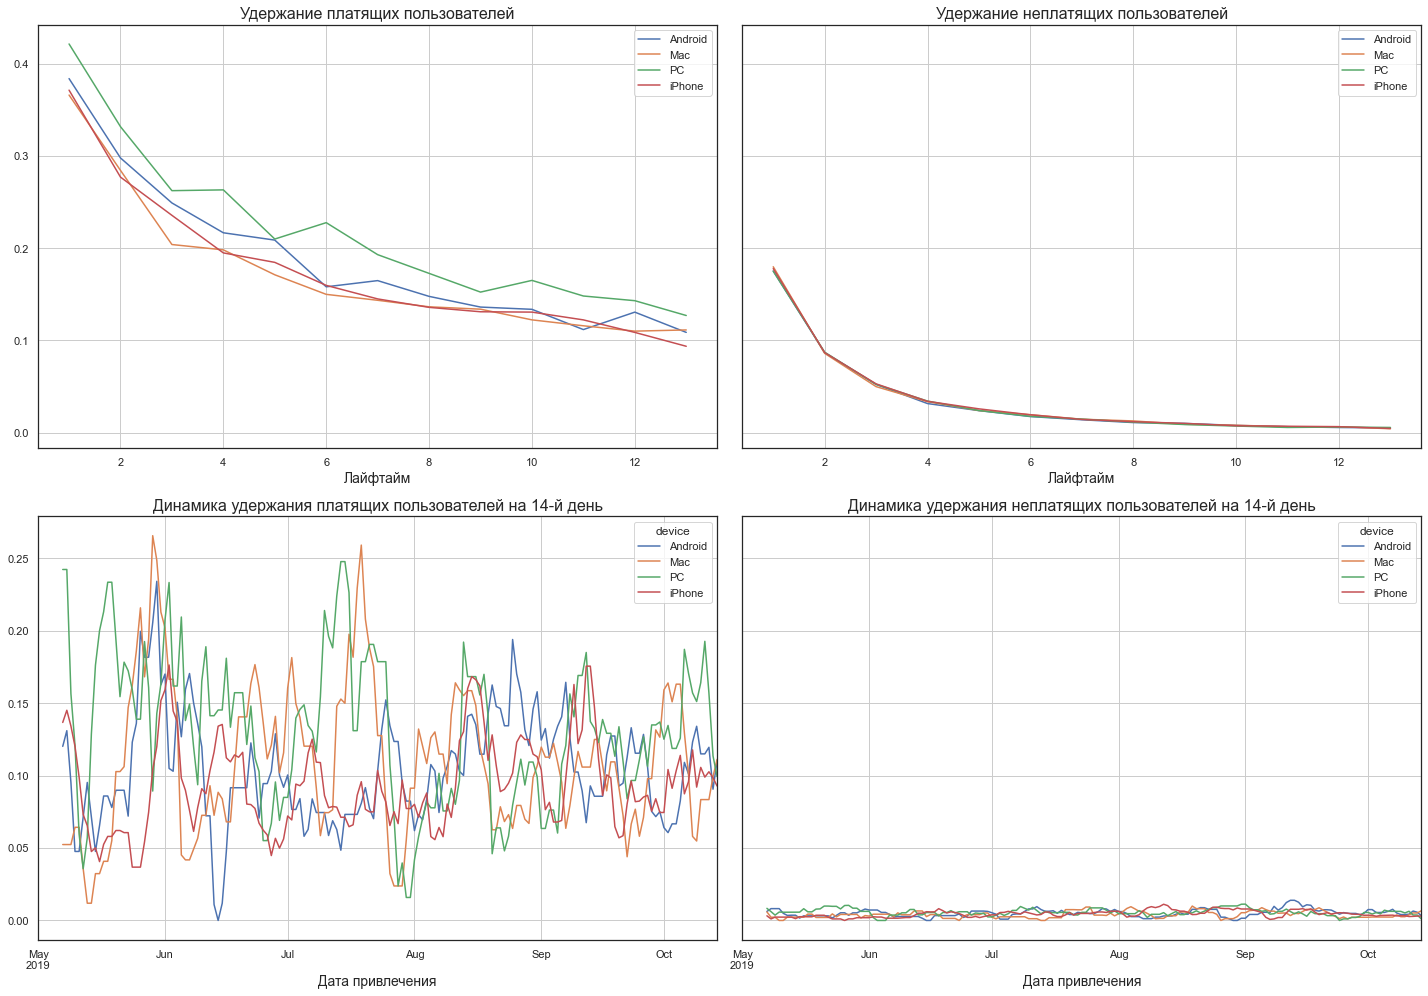

In [35]:
# смотрим удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device'])

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей выше неплатящих, что логично. Лучше всех удерживаются пользователи РС. Явных аутсайдеров нет.

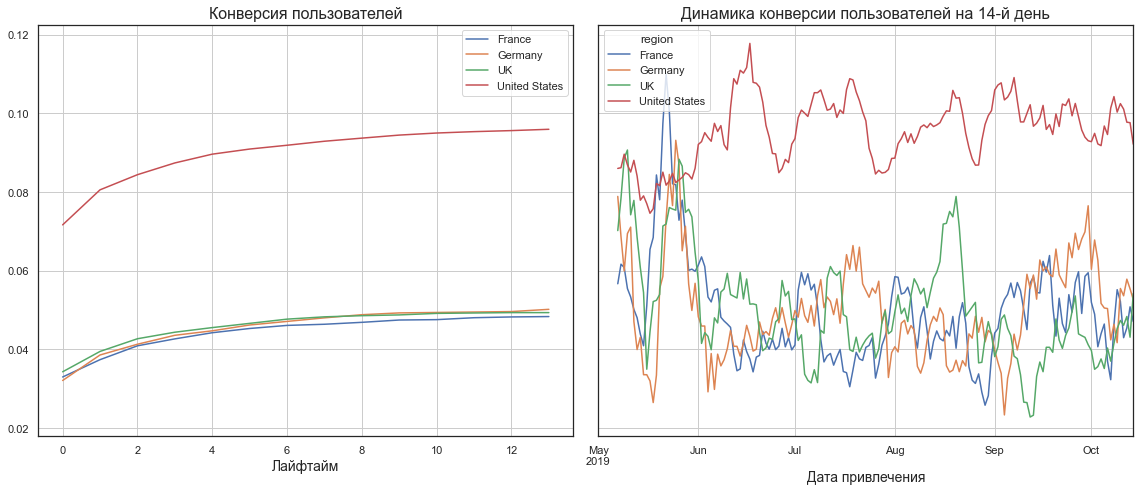

In [36]:
# смотрим конверсию с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи из Америки конвертируются заметно лучше остальных стран, причем это носит стабильный характер.

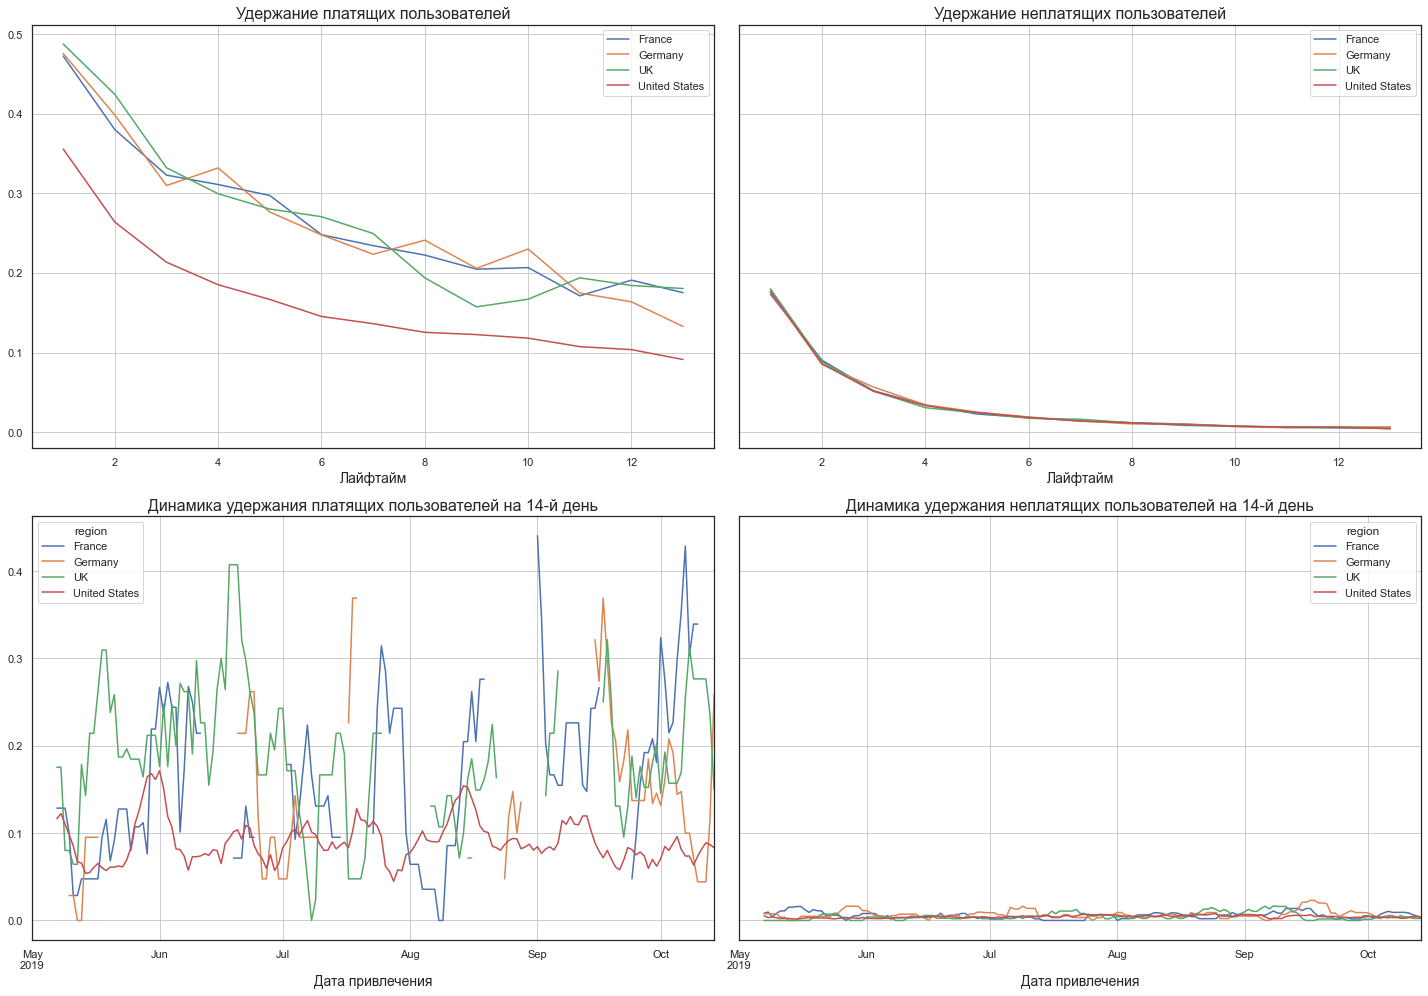

In [37]:
# смотрим удержание с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region'])

plot_retention(retention_grouped, retention_history, horizon_days)

Однако платящие пользователи из Америки стабильно хуже удерживаются. Это может являться одной из точек роста для компании.

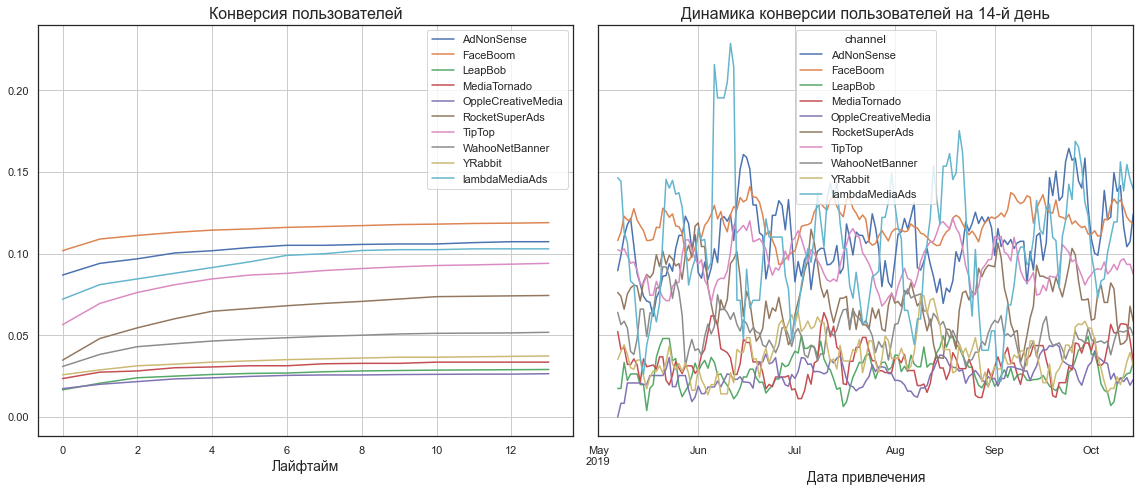

In [38]:
# смотрим конверсию с разбивкой по каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия очень неоднородна, но явным фаворитом здесь является канал FaceBoom с хорошей динамикой на протяжении всего исследуемого периода.

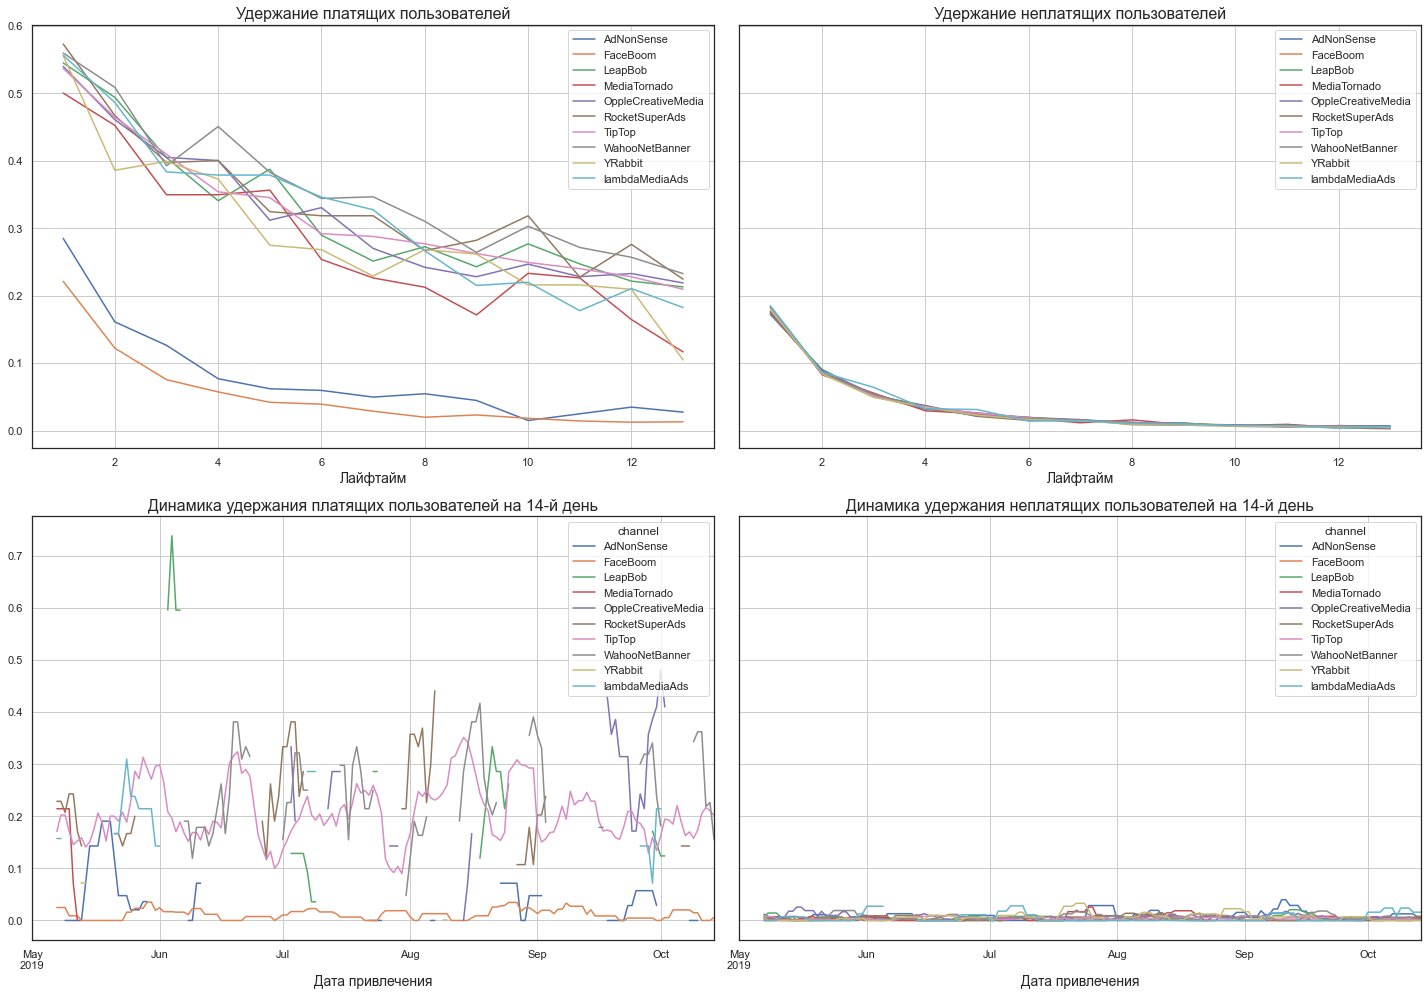

In [39]:
# смотрим удержание с разбивкой по каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, horizon_days)

Cтабильно плохо удерживаются клиенты, пришедшие из каналов AdNonSense и FaceBoom. Фактически их удержание повторяет динамику удержания для неплатящих пользователей, что довольно странно. Это может являться еще одной точкой роста для компании, учитывая их высокую конверсию.

## Выводы и рекомендации

На основании проведенных расчетов выявлено, что приложением пользуются в подавляющем большинстве случаев клиенты из Америки (67% пользователей). Доля платящих клиентов для них выше чем у остальных клиентов из других стран. В качестве устройств в основном используются айфоны. Владельцы айфонов и макбуков имеют более высокую платежеспособность относительно остальных девайсов. В основном пользователи пришли в приложение через органический трафик (38% пользователей), FaceBoom (19% пользователей) и TipTop (13% пользователей), общая доля которых составляет 70% пользователей. Доля платящих пользователи для каналов FaceBoom, AdNonSense, lambdaMediaAds и TipTop выше, чем для остальных источников.

Основная доля затрат приходится на каналы TipTop и FaceBoom, доля которых составила 52% и 31% соответственно. Из-за роста стоимости привлечения на одного клиента по каналу TipTop, общая стоисмость привлечения по всему проекту за полгода увеличилась в 1.7 раз и инвестиции, начиная с июня месяца, приносили лишь убытки.

В качестве рекомендаций отделу маркетинга предлагается:
1. Срочно снизить затраты на рекламу по каналу TipTop минимум на 60% для того, чтобы достичь двухнедельного порога окупаемости. По этой же причине следует снизить затраты на рекламу для каналов FaceBoom и AdNonSense минимум на 30% и 20% соответственно;
2. Американский рынок является очень привлекательным для инвестиций в маркетинг из-за высокой конверсии пользователей. На данный момент времени необходимо сделать акцент на развитие именно в этой стране. Например, отлично подойдут такие каналы как: YRabbit, MediaTomado и RocketSuperAds;
3. На европейском рынке отлично показывают себя такие источники как: lambdaMediaAds и LeapBob; 
4. Обратить внимание на аномально низкое удержание пользователей по каналам AdNonSense и FaceBoom относительно остальных каналов привлечения. Возможно, следует сделать контент более удобным и понятным пользователю.